In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm

In [5]:
Data = torch.load('dynamicData.pt')

In [6]:
Data.shape

torch.Size([3, 101])

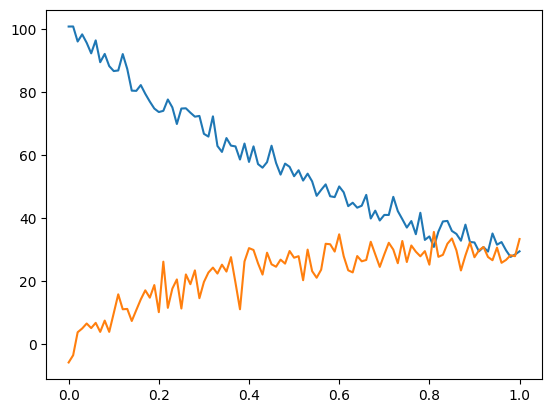

In [7]:
plt.plot(Data[0,:], Data[1,:])
plt.plot(Data[0,:], Data[2,:])



In [8]:
def fwd_solve(y0, theta, dt, nt):

  A = torch.zeros(2,2)
  Ka = 10**theta[0]
  CL = 10**theta[1]
  V  = 10**theta[2]
  A[0,0] = -Ka  
  A[1,0] = Ka/V
  A[1,1] = -CL/V

  # forward Euler
  Y = torch.zeros(2, nt+1)
  T = torch.zeros(nt+1)
  Y[:,0] = y0

  for i in range(nt):
    Y[:,i+1] = Y[:,i] + (A@Y[:,i])*dt
    T[i+1] = T[i] + dt
  return Y, T

In [9]:
y0 = Data[1:,0]
y0[1] = 0
print(y0)
t = Data[0,:]
dt = t[1]-t[0]
nt = 100

theta = 1/2*torch.rand(3)
Y, T = fwd_solve(y0, theta, dt, nt)

tensor([100.8023,   0.0000])


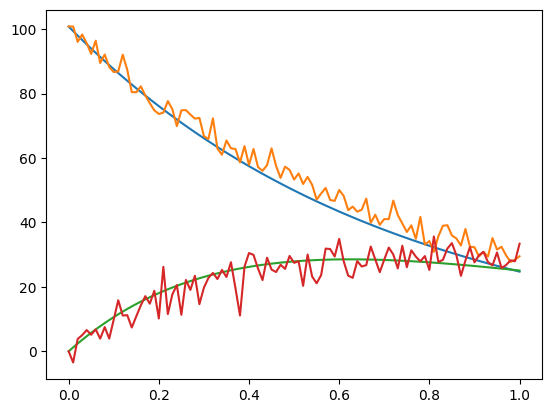

In [10]:
plt.plot(T,Y[0,:], T, Data[1,:])
plt.plot(T,Y[1,:], T, Data[2,:])


In [39]:
class odeSolve(nn.Module):
    
    def __init__(self, nt, dt):
 
        super().__init__()
        
        self.nt = nt
        self.dt = dt
        self.theta = nn.Parameter(1e-1*torch.rand(3))
                    
    def forward(self, y0):
      A = torch.zeros(2,2)
      Ka = 10**self.theta[0]
      CL = 10**self.theta[1]
      V  = 10**self.theta[2]
      A[0,0] = -Ka  
      A[1,0] = Ka/V
      A[1,1] = -CL/V

      # forward Euler
      y = y0
      T = torch.zeros(self.nt+1)
      Y = y0.unsqueeze(1)
      for i in range(self.nt):
        y        =  y + (A@y)*dt
        Y      = torch.cat((Y, y.unsqueeze(1)), dim=1)
        T[i+1] = T[i] + self.dt
      return Y, T

In [45]:
fwdsolve = odeSolve(100, 0.01)

In [46]:
y0 = torch.tensor([100.8023,   0.0000])
Y, T = fwdsolve(y0)

torch.Size([2, 101])


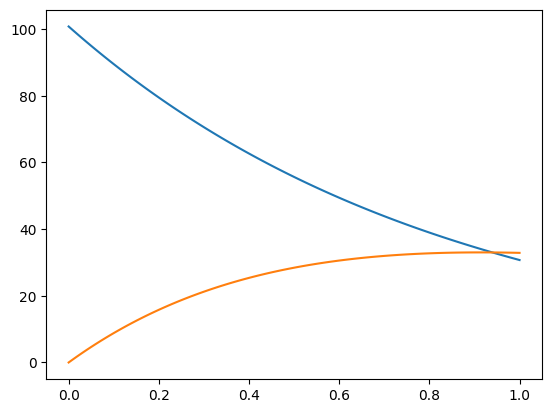

In [47]:
print(Y.shape)
plt.plot(T,Y[0,:].detach(), T,Y[1,:].detach())

In [51]:
from torch.optim import SGD
optimizer = SGD(fwdsolve.parameters(), lr=1e-5)


# Train the network
niterations = 1000
hh = torch.zeros(niterations)

for i in range(niterations):
    
    optimizer.zero_grad()
    # Compute the data misfit
    y0 = torch.tensor([100.8023,   0.0000])
    Y, T = fwdsolve(y0)
    Yobs = Data[1:,:]

    r = Y-Yobs
    loss = 0.5*torch.mean(r**2)
    
    loss.backward()   # Take derivatives
    optimizer.step()  # Update parameters
    hh[i] = loss.item()
    if i%100 == 0:
      print('iter = %3d    loss = %3.2e'%(i, loss))



iter =   0    loss = 1.55e+02
iter = 100    loss = 1.49e+02
iter = 200    loss = 1.49e+02
iter = 300    loss = 1.49e+02
iter = 400    loss = 1.49e+02
iter = 500    loss = 1.49e+02
iter = 600    loss = 1.49e+02
iter = 700    loss = 1.49e+02
iter = 800    loss = 1.49e+02
iter = 900    loss = 1.49e+02


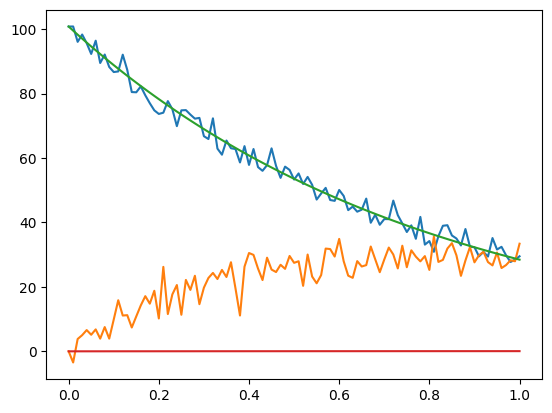

In [56]:
plt.plot(T,Yobs[0,:].detach(), T,Yobs[1,:].detach())
plt.plot(T,Y[0,:].detach(), T,Y[1,:].detach())

In [58]:
Y[1,:]

tensor([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0049, 0.0059, 0.0068, 0.0078,
        0.0087, 0.0096, 0.0105, 0.0113, 0.0122, 0.0131, 0.0139, 0.0147, 0.0156,
        0.0164, 0.0172, 0.0180, 0.0187, 0.0195, 0.0203, 0.0210, 0.0218, 0.0225,
        0.0232, 0.0239, 0.0246, 0.0253, 0.0260, 0.0267, 0.0273, 0.0280, 0.0286,
        0.0293, 0.0299, 0.0305, 0.0311, 0.0317, 0.0323, 0.0329, 0.0335, 0.0341,
        0.0346, 0.0352, 0.0357, 0.0363, 0.0368, 0.0373, 0.0379, 0.0384, 0.0389,
        0.0394, 0.0399, 0.0403, 0.0408, 0.0413, 0.0418, 0.0422, 0.0427, 0.0431,
        0.0436, 0.0440, 0.0444, 0.0449, 0.0453, 0.0457, 0.0461, 0.0465, 0.0469,
        0.0473, 0.0477, 0.0480, 0.0484, 0.0488, 0.0491, 0.0495, 0.0499, 0.0502,
        0.0505, 0.0509, 0.0512, 0.0515, 0.0519, 0.0522, 0.0525, 0.0528, 0.0531,
        0.0534, 0.0537, 0.0540, 0.0543, 0.0546, 0.0549, 0.0552, 0.0554, 0.0557,
        0.0560, 0.0562], grad_fn=<SliceBackward0>)